## Making pleasing maps with cartopy

To make a pretty, publication grade map for your study area look no further than cartopy.

In this tutorial we will walk through generating a basemap with:
- Bathymetry/topography
- Coastline
- Scatter data
- Location labels
- Inset map
- Legend

This code can be generalised to any region you wish to map

First we import some modules for manipulating and plotting data


In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import xarray as xr

Then we import cartopy itself

In [2]:
import cartopy

In addition, we import cartopy's **coordinate reference system** submodule:

In [3]:
import cartopy.crs as ccrs

A few other modules and functions which we will use later to add cool stuff to our plots. Also updating font sizes for improved readability

In [4]:
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from cartopy.io import shapereader

plt.rcParams.update({'font.size': 20})
SMALL_SIZE = 22
MEDIUM_SIZE = 22
LARGE_SIZE = 26
plt.rc('font', size=SMALL_SIZE)
plt.rc('xtick', labelsize=SMALL_SIZE)
plt.rc('ytick', labelsize=SMALL_SIZE)
plt.rc('axes', titlesize=SMALL_SIZE)
plt.rc('legend', fontsize=SMALL_SIZE)

### Note on bathymetry data
To save space and time I have subset the bathymetry plotted in this example. If you wish to map a different area you will need to download the GEBCO topography data found [here](https://www.gebco.net/data_and_products/gridded_bathymetry_data) then uncomment and run the code block below. I suggest doing this once only as it takes some time! After running this your bathymetry selection will replace the example bathy in the file bathy.nc

In [5]:
from netCDF4 import Dataset
# A function to find the nearest item to a given point. Very handy with coordinates
def argnearest(items,pivot):
    near_item=min(items, key=lambda x: abs(x - pivot))
    for i in range(len(items)): 
        if items[i]==near_item:
            return i
# Enter the coordinates of your desired box here [lon,lat] -180<lon<180
SW_vertex = [-42,-60]
NE_vertex = [-23,-50]
 
#gebco = Dataset("/path/to/your/GEBCO/folder/GEBCO_2014_2D.nc", "r", format="NETCDF4")
gebco = Dataset("/media/callum/hd/Documents/global_datasets/GEBCO_2019/GEBCO_2019.nc", "r", format="NETCDF4")
all_lat = gebco['lat'][:]
all_lon = gebco['lon'][:]


SW_indices = [argnearest(all_lon,SW_vertex[0]),argnearest(all_lat,SW_vertex[1])]
NE_indices = [argnearest(all_lon,NE_vertex[0]),argnearest(all_lat,NE_vertex[1])]

bathy_lon = all_lon[SW_indices[0]:NE_indices[0]+1]
bathy_lat = all_lat[SW_indices[1]:NE_indices[1]+1]

bath_lat_selec = gebco['elevation'][np.logical_and(all_lat>=bathy_lat[0],all_lat<=bathy_lat[-1])][:]
bathy_h = bath_lat_selec[:,np.logical_and(all_lon>=bathy_lon[0],all_lon<=bathy_lon[-1])]

In [6]:
# To save our bathymetry data
xlon = xr.IndexVariable(dims="longitude", data=bathy_lon, attrs={"units": "degrees_east"})
xlat = xr.IndexVariable(dims="latitude", data=bathy_lat, attrs={"units": "degrees_north"})

bathy_arr = xr.DataArray(
    bathy_h,
    name="bathymetry",
    attrs={"units": "metres"},
    dims=("latitude", "longitude"),
    coords={"longitude": xlon, "latitude": xlat},
)
bathy_arr.to_netcdf('bathy.nc')

Load the stored bathymetry data

In [7]:
bathy_ds = xr.open_dataset('./bathy.nc')
bathy_lon, bathy_lat, bathy_h = bathy_ds.bathymetry.longitude, bathy_ds.bathymetry.latitude, bathy_ds.bathymetry.values

We're just interested in bathy here, so set any height values greater than 0 to to 0 and set contour levels to plot later

In [8]:
bathy_h[bathy_h>0] = 0
bathy_conts = np.arange(-9000,500,500)

Here we load some scatter data from a two column csv for plotting later

In [9]:
# Load some scatter data of smaple locations near South Georgia
data = pd.read_csv('scatter_coords.csv')
lons = data.Longitude.values
lats = data.Latitude.values

# Subset of sampling locations
sample_lon = lons[[0,2,7]]
sample_lat = lats[[0,2,7]]


Now to make the map itself. First we define our coordinate system, create figure and axes instances and set the plotting extent in degrees [West, East, South, North]

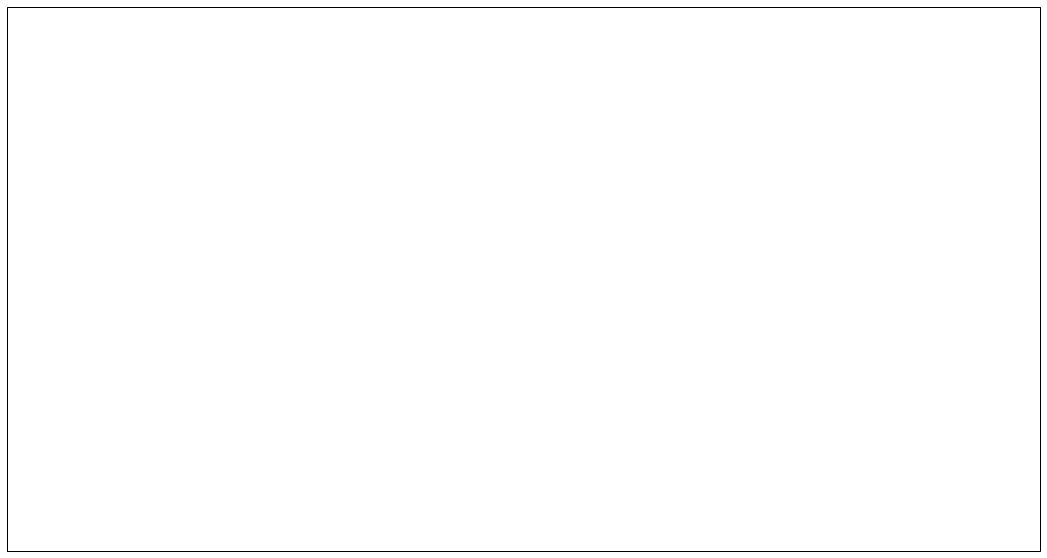

In [10]:
coord=ccrs.PlateCarree()
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(111, projection=coord)
ax.set_extent([-42, -23, -60, -50], crs=coord)

Now we contour the bathymetry data

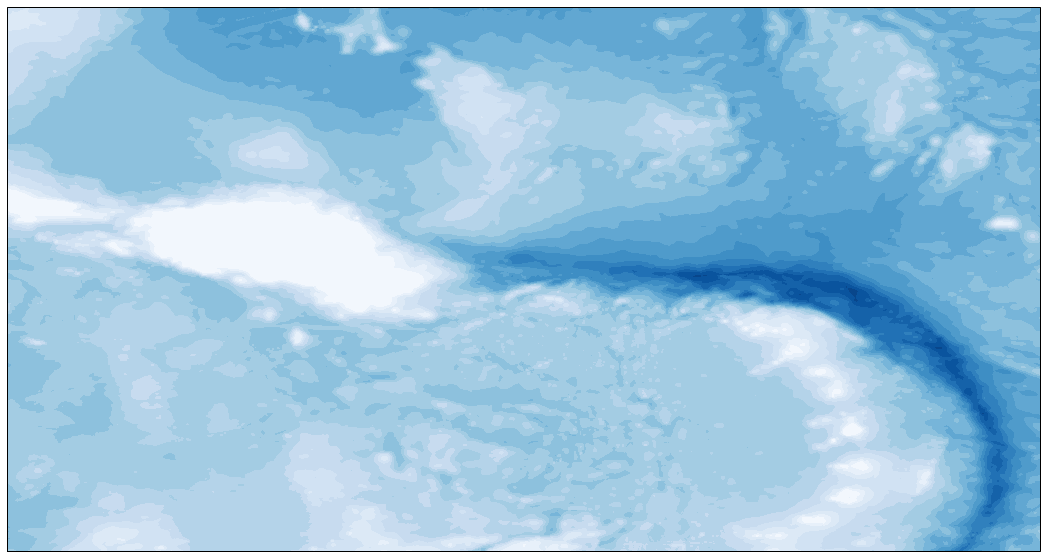

In [11]:
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(111, projection=coord)
ax.set_extent([-42, -23, -60, -50], crs=coord)
bathy=ax.contourf(bathy_lon,bathy_lat,bathy_h,bathy_conts,transform=coord,cmap='Blues_r')

A good start. To make it more map like we add gridlines, formatted labels and a colorbar

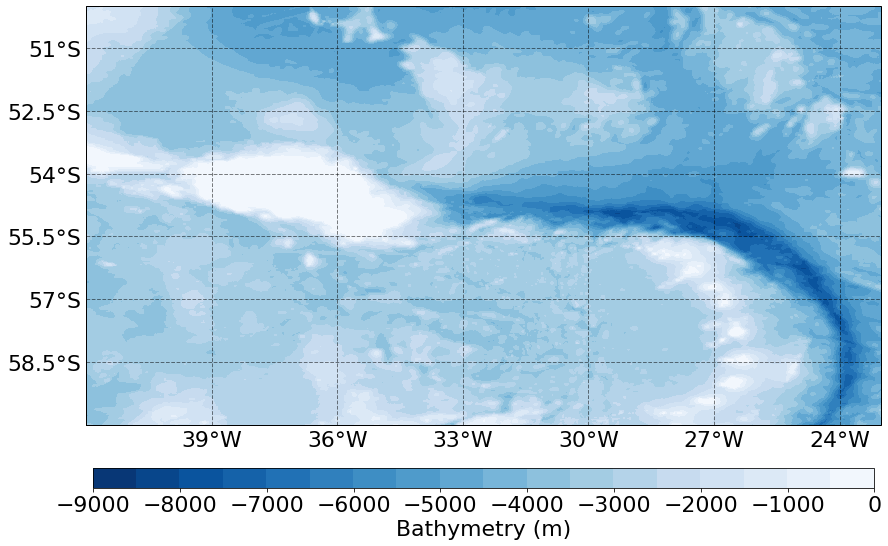

In [12]:
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(111, projection=coord)
ax.set_extent([-42, -23, -60, -50], crs=coord)
bathy=ax.contourf(bathy_lon,bathy_lat,bathy_h,bathy_conts,transform=coord,cmap='Blues_r')

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='k', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.ylabels_right = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.ylines = True
gl.xlines = True
fig.colorbar(bathy,ax=ax,orientation='horizontal',label='Bathymetry (m)',shrink=0.7,pad=0.08,aspect=40);

Now to add a few more features. First coastlines from cartopy's natural features toolbox. Then scatters of the samples we imported earlier

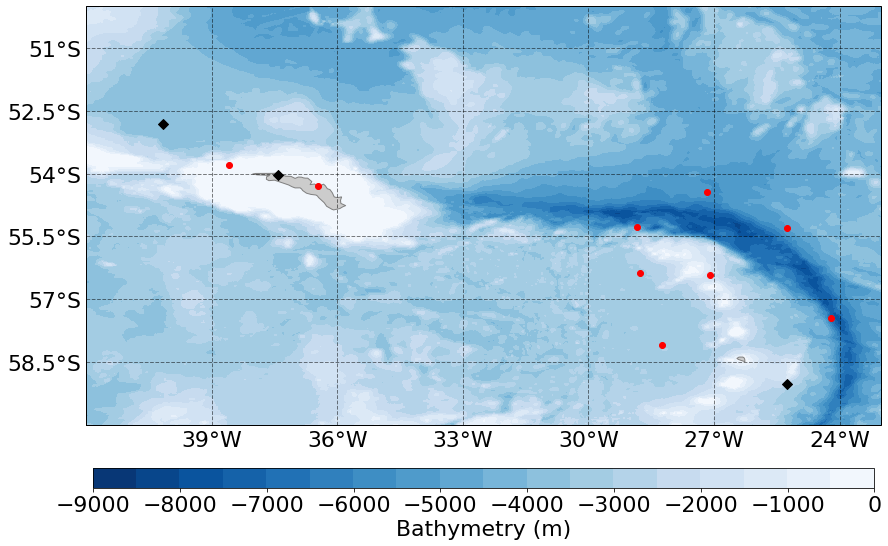

In [13]:
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(111, projection=coord)
ax.set_extent([-42, -23, -60, -50], crs=coord)
bathy=ax.contourf(bathy_lon,bathy_lat,bathy_h,bathy_conts,transform=coord,cmap='Blues_r')

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='k', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.ylabels_right = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.ylines = True
gl.xlines = True
fig.colorbar(bathy,ax=ax,orientation='horizontal',label='Bathymetry (m)',shrink=0.7,pad=0.08,aspect=40)


feature = cartopy.feature.NaturalEarthFeature(name='coastline',
                                              category='physical',
                                              scale='50m',
                                              edgecolor='0.5',
                                              facecolor='0.8')
ax.add_feature(feature)
ax.scatter(lons,lats,zorder=5,color='red',label='Samples collected')
ax.scatter(sample_lon,sample_lat,zorder=10,color='k',marker='D',s=50,label='Samples sequenced');

To finish off the map we add a legend for the scatter plot, an inset map showing the area at a larger scale and some text identifying the islands

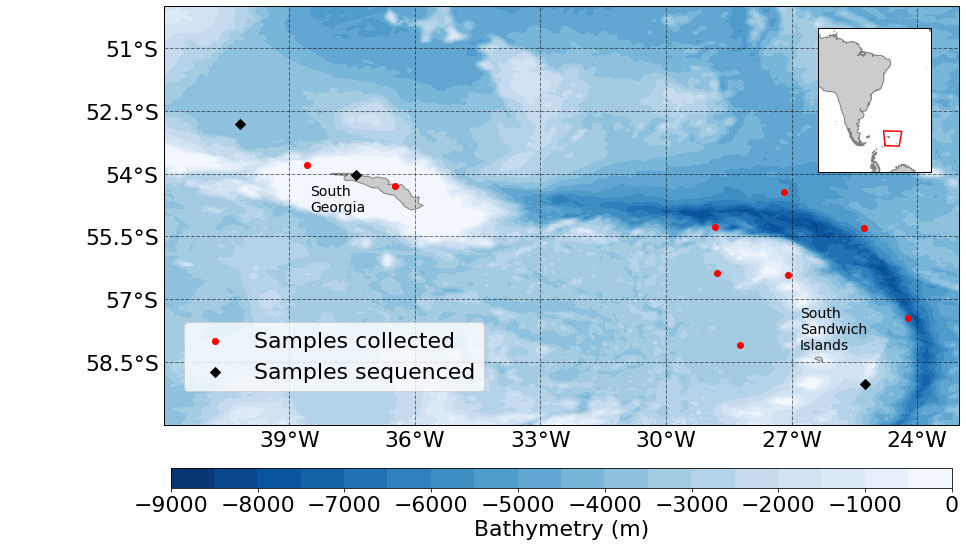

In [14]:
# Initiate the figure and axes, specifying the projection.
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(111, projection=coord)

# Set the extent of the map [W,E,S,N]
ax.set_extent([-42, -23, -60, -50], crs=coord)

# Plot the bathymetry here, could change the contour levels by making a new bathy_conts
# or try a different colormap
bathy=ax.contourf(bathy_lon,bathy_lat,bathy_h,bathy_conts,transform=coord,cmap='Blues_r')

# Set the color and style of the gridlines
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='k', alpha=0.5, linestyle='--')

# Format those gridlines, turn off labels on the top and right side
gl.xlabels_top = False
gl.ylabels_right = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.ylines = True
gl.xlines = True

# Add a colorbar for the bathymetry data
fig.colorbar(bathy,ax=ax,orientation='horizontal',label='Bathymetry (m)',shrink=0.7,pad=0.08,aspect=40)

# Add the coastlines
ax.add_feature(feature)

# Add the scatter data, we could change the symbols
ax.scatter(lons,lats,zorder=5,color='red',label='Samples collected')
ax.scatter(sample_lon,sample_lat,zorder=10,color='k',marker='D',s=50,label='Samples sequenced')

# Add the legend, try changing its position
fig .legend( bbox_to_anchor=(0.12,0.2),loc='lower left')

# Here we add the inset map sub axes in the top right, note the different projection
tr2=ccrs.Stereographic(central_latitude=-55,central_longitude=-35)
sub_ax = plt.axes([0.63, 0.65, 0.2, 0.2], projection=ccrs.Stereographic(central_latitude=-55,central_longitude=-35))

# Try changing the extent of our inset map here
sub_ax.set_extent([-70, -15, -75, 10])

# Here we make a line that plots the vertices of our main plot to put on the inset map
x_co = [-42,-42,-23,-23,-42]
y_co = [-60,-50,-50,-60,-60]
sub_ax.add_feature(feature)
sub_ax.plot(x_co,y_co,transform=coord,zorder=10,color='red')

# Finally we add a couple of text labels for the islands
ax.text(-38.5,-54.9,'South\nGeorgia',fontsize=14)
ax.text(-26.8,-58.2,'South\nSandwich\nIslands',fontsize=14);